In [1]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import zipfile
import time
from PIL import Image
from tqdm import tqdm

d:\Users\germa\anaconda3\envs\DL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Users\germa\anaconda3\envs\DL\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
from data.setupData import load_voc_dataset, _parse_features, load_coco_dataset
from model.augmentations import RandomHorizontalFlip, RandomMirror, RandomZoom, RandomTranslate, AddNoise, GaussianBlur, RandomGamma, RandomRotate, AugProbability, Converter, Ada, build_augmenter
from utils.visualize import visualize_boxes, visualize_outputs, plot_grid_anchors
from utils.postprocess.postprocessing import bbox_iou, decode_model_outputs, non_max_suppression, NMS
from utils.callbacks import create_callbacks
from utils.preprocess.transform_bboxes import TransformBoxes
from utils.loss import lossFunction
from model.model import Mean, MyModel, make_dummy_model
from tools.read_tfRecord import read_tfrecord, get_tfrecordkeys
from model.config import *

# Load Data

In [3]:
ds_train = load_coco_dataset(args, coco_val_ds_path, augment_func = None, split = 'train') ######################### USE VAL FOR NOW AS TRAIN IS LONG

Loading train dataset from D:\DL-CV-ML Projects\Object Detection\repo\data\COCO_data_val.tfrecord...


In [4]:
tmvm = iter(ds_train)

In [5]:
kvsdk = next(tmvm)

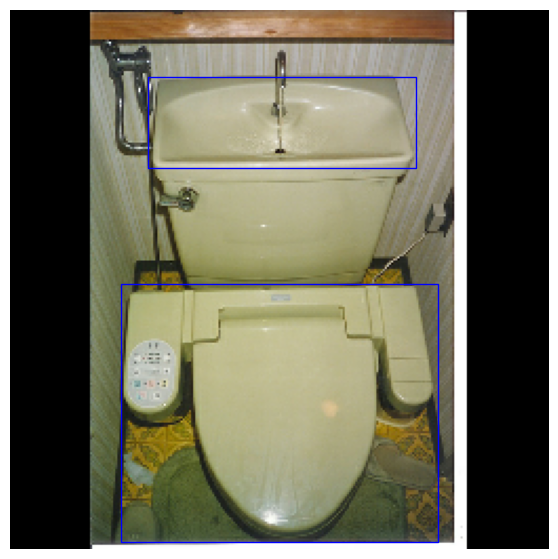

In [6]:
i = 0
img_to_test = kvsdk[0][i]
its_bboxes = kvsdk[1][i]
img_y = img_to_test.shape[0]
img_x = img_to_test.shape[1]
scale = tf.constant([img_y, img_x, img_y, img_x], dtype=tf.float32)
visualize_boxes(img_to_test, its_bboxes[..., :-1]*scale, figsize=(7, 7), linewidth=1, color=[0, 0, 1])

In [7]:
setup_bboxes = TransformBoxes(args, grid_sizes, norm_anchors)

In [8]:
grid = setup_bboxes(kvsdk[1])

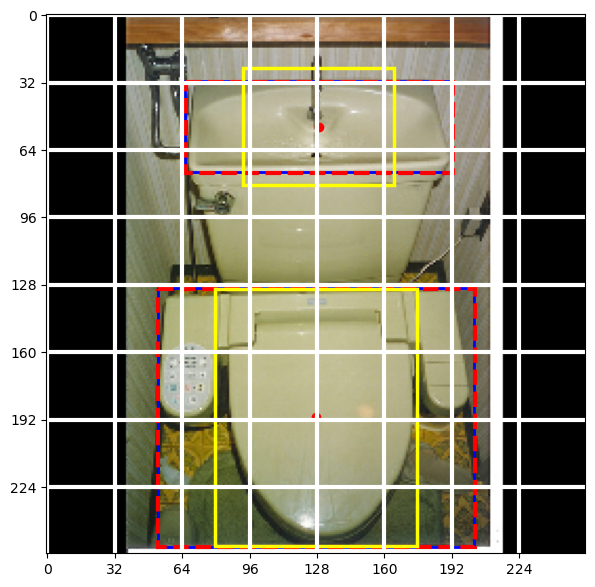

Total bboxes: 2, Total anchors: 2


In [10]:
c = 0
plot_grid_anchors(img_to_test, its_bboxes, grid[c], (7, 7), norm_anchors[c], False, ['bbox', 'anchors', 'prediction']) # ['bbox', 'prediction', 'anchors']

# Make Sure Augmentations Work

In [11]:
augmenter = Ada(aug_functions=augmentations, img_size=args.img_size, initial_probability=0.0, switch=True)

In [12]:
augmenter.update(tf.constant(0.5))
print(augmenter.probability)
test_ada = augmenter(kvsdk, training=True)

<tf.Variable 'ada_p:0' shape=(1, 1) dtype=float32, numpy=array([[0.2496521]], dtype=float32)>


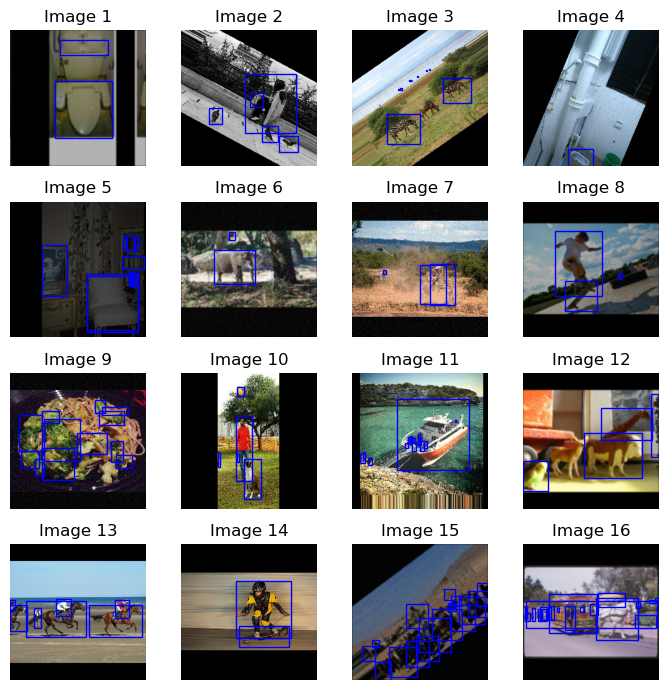

In [13]:
scale = tf.constant([args.img_size[0], args.img_size[1], args.img_size[0], args.img_size[1]], dtype=tf.float32)
visualize_outputs(test_ada[0], test_ada[1][..., :-1], scale=scale, figsize=(7, 7), linewidth=1, color=[0, 0, 1])

In [14]:
grid2 = setup_bboxes(test_ada[1])

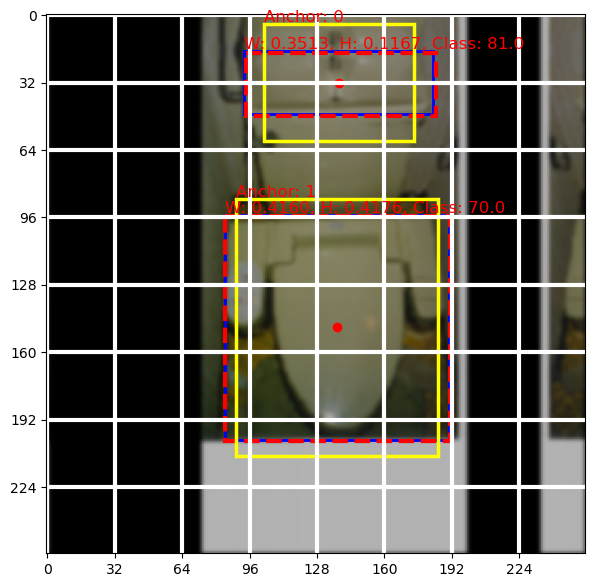

Total bboxes: 2, Total anchors: 2


In [15]:
c = 0
indx = 0
plot_grid_anchors(test_ada[0][indx], test_ada[1][indx], grid2[c][indx], (7, 7), norm_anchors[c], True, ['bbox', 'anchors', 'prediction']) # ['bbox', 'prediction', 'anchors']

# Train

In [16]:
def make_dummy_model(img_size, grid_sizes, classes = 100, num_anchors = 3):

    if len(img_size) == 2:
        shape = (img_size[0], img_size[1], 3)
    if len(img_size) == 3:
        shape = img_size
    
    inputs = tf.keras.Input(shape=shape)
    x = layers.Conv2D(32, kernel_size=3, strides=1, padding="same", name='Conv1')(inputs)
    x = layers.BatchNormalization(name='BN1')(x)
    x = layers.Activation("relu", name='Act1')(x)

    x = layers.Conv2D(32, kernel_size=3, strides=4, padding="same", name='Conv2')(x)
    x = layers.BatchNormalization(name='BN2')(x)
    x = layers.Activation("relu", name='Act2')(x)

    x = layers.Conv2D(32, kernel_size=3, strides=4, padding="same", name='Conv3')(x)
    x = layers.BatchNormalization(name='BN3')(x)
    x = layers.Activation("relu", name='Act3')(x)

    x = layers.Conv2D(32, kernel_size=3, strides=2, padding="same", name='Conv4')(x)
    x = layers.BatchNormalization(name='BN4')(x)
    x = layers.Activation("relu", name='Act4')(x)

    filters = num_anchors * (4 + 1 + classes)
    x = layers.Conv2D(filters=filters, kernel_size=1, padding="same", name='FinalConv1')(x)
    out1 = layers.Reshape((grid_sizes[0], grid_sizes[0], num_anchors, classes + 5))(x)

    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(filters=filters, kernel_size=1, padding="same", name='FinalConv2')(x)
    out2 = layers.Reshape((grid_sizes[1], grid_sizes[1], num_anchors, classes + 5))(x)

    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(filters=filters, kernel_size=1, padding="same", name='FinalConv3')(x)
    out3 = layers.Reshape((grid_sizes[2], grid_sizes[2], num_anchors, classes + 5))(x)

    model = tf.keras.Model(inputs=inputs, outputs=[out1, out2, out3])
    return model

In [22]:
def setupModel(args, grid_sizes, anchors, augmentations, save_model_path, config_opt):

    augment_func = Ada(aug_functions=augmentations, img_size=args.img_size, initial_probability=args.ada_initial_probability, switch=True)
    test_mymodel = MyModel(img_size=args.img_size, augment_func=augment_func, grid_sizes=grid_sizes, anchors=anchors, args=args)

    loss_list = []
    for i in range(anchors.shape[0]):
        loss = lossFunction(anchors[i], args.ignore_thresh, args.lambda_box, args.lambda_noobj, args.lambda_class)
        loss_list.append(loss)
    callback_list = create_callbacks(save_model_path, args, test_mymodel, anchors, img_path = img_path)

    if args.optimizer == 'scd':

        learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
        learning_rate_boundaries = [125, 250, 500, 240000, 360000]
        learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(boundaries=learning_rate_boundaries, values=learning_rates)
        optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)

    if args.optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam()
        optimizer = optimizer.from_config(config=config_opt)

    else:
        optimizer = tf.keras.optimizers.get(args.optimizer)
        optimizer = optimizer.from_config(config=config_opt)

    return test_mymodel, loss_list, callback_list, optimizer

In [23]:
test_mymodel, loss_list, callbacks_list, optimizer = setupModel(args, grid_sizes, norm_anchors, augmentations, save_model_path, config_opt)

In [24]:
test_mymodel.compile(optimizer=optimizer, metrics = [Mean(name="aug_probability")], loss=loss_list)

Epoch 1/5


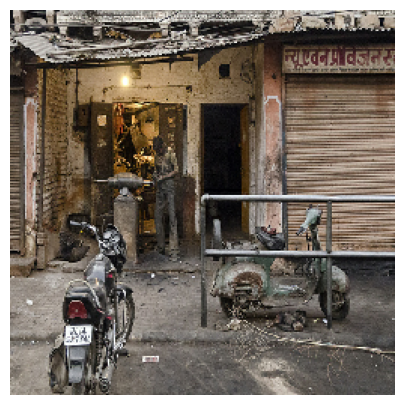

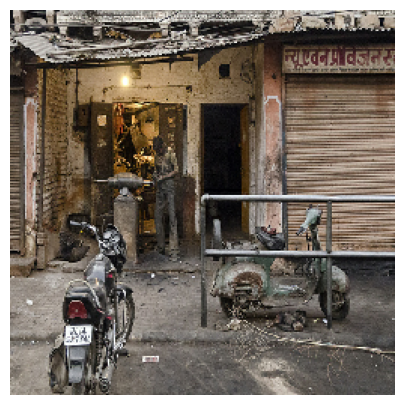

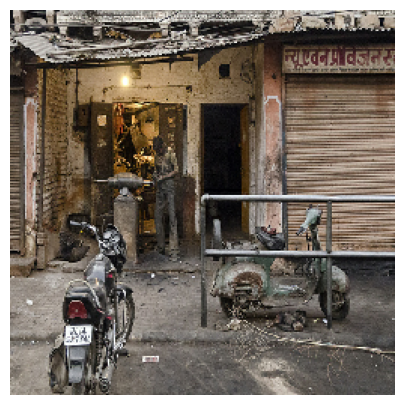

312/312 [==============================] - 89s 229ms/step - loss: 129.8619 - output_1_loss: 39.0319 - output_2_loss: 44.3639 - output_3_loss: 46.4661 - aug_probability: 0.0293 - iou_tracker: 0.1020

Epoch 1: loss improved from inf to 129.86192321777344, saving model to D:\DL-CV-ML Projects\Object Detection\repo\Object Detection\model\model_weights\model.h5
Epoch 2/5
312/312 [==============================] - 72s 231ms/step - loss: 118.2183 - output_1_loss: 35.9323 - output_2_loss: 42.2066 - output_3_loss: 40.0795 - aug_probability: 0.0289 - iou_tracker: 0.1009

Epoch 2: loss improved from 129.86192321777344 to 118.21832275390625, saving model to D:\DL-CV-ML Projects\Object Detection\repo\Object Detection\model\model_weights\model.h5
Epoch 3/5


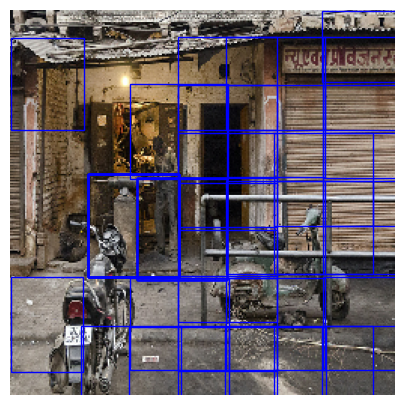

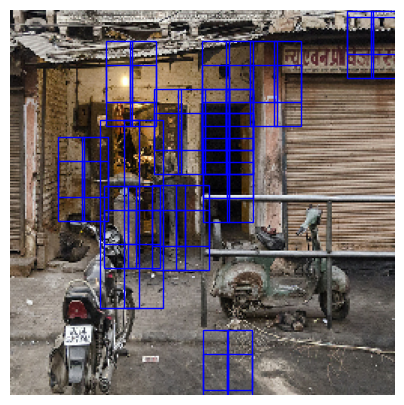

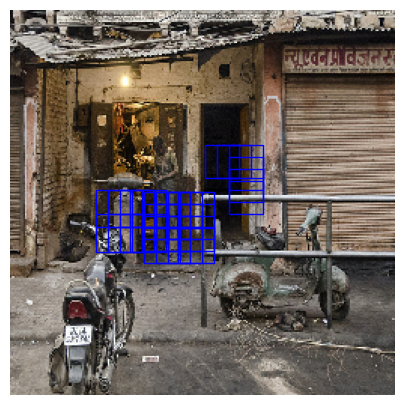

312/312 [==============================] - 74s 234ms/step - loss: 115.1677 - output_1_loss: 35.0576 - output_2_loss: 41.4794 - output_3_loss: 38.6308 - aug_probability: 0.0300 - iou_tracker: 0.1043

Epoch 3: loss improved from 118.21832275390625 to 115.16767883300781, saving model to D:\DL-CV-ML Projects\Object Detection\repo\Object Detection\model\model_weights\model.h5
Epoch 4/5
312/312 [==============================] - 73s 235ms/step - loss: 113.6170 - output_1_loss: 34.4951 - output_2_loss: 41.1823 - output_3_loss: 37.9396 - aug_probability: 0.0307 - iou_tracker: 0.1063

Epoch 4: loss improved from 115.16767883300781 to 113.61697387695312, saving model to D:\DL-CV-ML Projects\Object Detection\repo\Object Detection\model\model_weights\model.h5
Epoch 5/5
312/312 [==============================] - 77s 245ms/step - loss: 112.5732 - output_1_loss: 34.0226 - output_2_loss: 40.9925 - output_3_loss: 37.5581 - aug_probability: 0.0321 - iou_tracker: 0.1105

Epoch 5: loss improved from 113.6

In [25]:
test_mymodel.fit(ds_train, epochs=5, callbacks=callbacks_list)